In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer,BertForSequenceClassification
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer,RobertaForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import torch.nn as nn
from transformers import AdamW
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

df_stack = pd.read_csv('stack-exchange.annotated.csv')
df_wiki = pd.read_csv('wikipedia.annotated.csv')

columns = ['Request','Score1', 'Score2', 'Score3', 'Score4','Score5','Normalized Score']
df_final = df_wiki.append(df_stack)
df_final.drop(['Community','Id','TurkId1', 'TurkId2', 'TurkId3', 'TurkId4', 'TurkId5'],axis=1,inplace=True)
def remove_url(request):
    try:
        request = request.replace('<url>','')
        request = "".join([i for i in request if i not in string.punctuation])   
        request = re.sub(r'^https?:\/\/.*[\r\n]*', '', request)
        request = re.sub(r'^http.*[\r\n]*', '', request)
        request = re.sub(" \d+", " ", request)
    except:
        pass
    return request

df_final.loc[:,'Request'] = df_final.Request.apply(lambda x: remove_url(x))

#Randomly shuffle the data
# df_final = df_final.sample(frac=1)
conditions = [(df_final['Normalized Score']<-0.5),(-0.5<=df_final['Normalized Score']) & (df_final['Normalized Score']<=0.5), (df_final['Normalized Score']>0.5)]
values = [0,1,2]
df_final['label_1'] = np.select(conditions,values)

sentences = df_final.Request.values
labels = df_final.label_1.values

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_inputs, val_inputs,train_labels,val_labels = train_test_split(sentences,labels, 
                                            random_state=42, test_size=0.1,stratify=labels)
tokens_train = tokenizer(
    train_inputs.tolist(),
    padding = True , truncation=True,return_tensors='pt',
    add_special_tokens=False
)

tokens_val = tokenizer(
    val_inputs.tolist(),
    padding=True, truncation=True,return_tensors='pt',
    add_special_tokens=False
)

In [4]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=3)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [6]:
batch_size = 8

train_ids = tokens_train['input_ids']
train_mask = tokens_train['attention_mask']
train_y = torch.tensor(train_labels.tolist())

val_ids = tokens_val['input_ids']
val_mask = tokens_val['attention_mask']
val_y = torch.tensor(val_labels.tolist())

train_data = TensorDataset(train_ids, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(val_ids, val_mask, val_y)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [7]:
from transformers import AdamW
from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
                "linear",optimizer=optimizer,num_warmup_steps=0,
                num_training_steps=num_training_steps
)


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(" ")

In [9]:
from tqdm.auto import tqdm
train_loss = []
progress_bar = tqdm(range(num_training_steps))
model.train()
for num_epoch in range(num_epochs):
    for step, batch in enumerate(train_dataloader):
        batch = [r.to(device) for r in batch]
        ids,masks,labels = batch
        outputs = model(input_ids=ids,attention_mask=masks,labels=labels)
        loss = outputs.loss
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/3699 [00:00<?, ?it/s]

In [10]:
torch.save(model.state_dict(), 'bert_vanilla.pth')

In [11]:
from datasets import load_metric
predictions = []
labels = []
metric = load_metric('accuracy')
model.eval()
for step, batch in enumerate(validation_dataloader):
    batch = [r.to(device) for r in batch]
    ids,masks,label = batch
    with torch.no_grad():
        outputs = model(input_ids=ids,attention_mask=masks)
    logits = outputs.logits
    preds = torch.argmax(logits,dim=-1)
    predictions.append(preds.cpu())
    labels.append(label.cpu())
    metric.add_batch(predictions=preds,references=label)

In [12]:
metric.compute()

{'accuracy': 0.5684306569343066}

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [14]:
list_preds = [int(pred) for prediction in predictions for pred in prediction]
list_labels = [int(lbl) for label in labels for lbl in label]

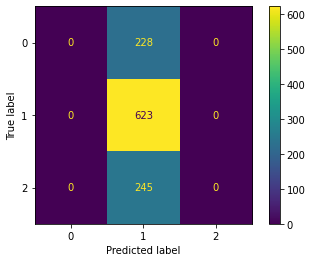

In [15]:
display_labels = [0,1,2]
cm = confusion_matrix(list_labels,list_preds,labels=display_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
disp = disp.plot()

plt.show()